In [5]:
import networkx as nx
import matplotlib.pyplot as plt

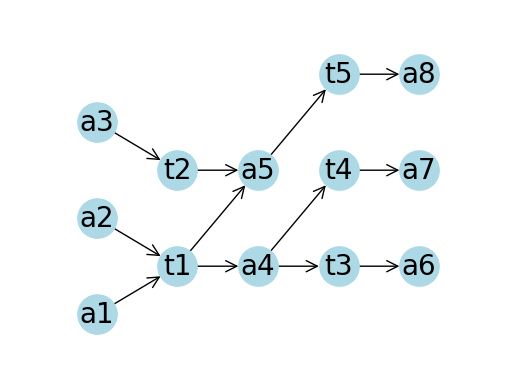

In [53]:
import networkx as nx
import matplotlib.pyplot as plt

G = nx.DiGraph([("a1", "t1"), ("a2", "t1"), ("a3", "t2"), ("t1", "a4"), ("t1", "a5"), ("t2", "a5"), ("a5", "t5"), ("a4", "t4"), ("a4", "t3"),("t3", "a6"), ("t4","a7"), ("t5", "a8")])

node_types = {"a1": "address", "a2": "address", "a3": "address", "t1": "transaction", "t2": "transaction", "a4": "address", "a5": "address", "t3": "transaction", "t4": "transaction", "t5": "transaction", "a6": "address", "a7": "address", "a8": "address",}
nx.set_node_attributes(G, node_types, "type")

# Group nodes by column
first_nodes = ["a1", "a2", "a3"]
second_nodes = ["t1", "t2"]
third_nodes = ["a4", "a5"]
forth_nodes = ["t3", "t4", "t5"]
fifth_nodes = ["a6", "a7", "a8"]

# Set the position according to column (x-coord)
pos = {n: (0, i) for i, n in enumerate(first_nodes)}
pos.update({n: (1, i + 0.5) for i, n in enumerate(second_nodes)})
pos.update({n: (2, i + 0.5) for i, n in enumerate(third_nodes)})
pos.update({n: (3, i + 0.5) for i, n in enumerate(forth_nodes)})
pos.update({n: (4, i + 0.5) for i, n in enumerate(fifth_nodes)})

options = {
    "with_labels": True,
    "node_color": "lightblue",
    "node_size": 800,
    "arrowstyle": "->",
    "arrowsize": 20,
    "linewidths": 1,
    "font_size": 20,
}

nx.draw_networkx(G, pos=pos, **options)

ax = plt.gca()
ax.margins(0.20)
plt.axis("off")
plt.show()

In [81]:
def find_transactions_with_common_address(G):
    address_nodes = [n for n in G.nodes() if G.nodes[n]["type"] == "address"]

    # Find all pairs of transactions that share a common address node
    transactions_with_common_address = []
    for address_node in address_nodes:
        neighbors = list(G.neighbors(address_node))
        transaction_neighbors = [n for n in neighbors if G.nodes[n]["type"] == "transaction"]
        if len(transaction_neighbors) > 1:
            for i, t1 in enumerate(transaction_neighbors[:-1]):
                for t2 in transaction_neighbors[i+1:]:
                    t1_inputs = set(G.predecessors(t1))
                    t2_inputs = set(G.predecessors(t2))
                    if not bool(t1_inputs.intersection(t2_inputs)):
                        pair = (t1, t2) if t1 < t2 else (t2, t1)
                        if pair not in transactions_with_common_address:
                            transactions_with_common_address.append(pair)

    for address_node in address_nodes:
        neighbors = list(G.neighbors(address_node))
        transaction_neighbors = [n for n in neighbors if G.nodes[n]["type"] == "transaction"]
        for t in transaction_neighbors:
            address_neighbors = [n for n in G.neighbors(t) if G.nodes[n]["type"] == "address"]
            for a in address_neighbors:
                other_transactions = [n for n in G.neighbors(a) if G.nodes[n]["type"] == "transaction" and n != t]
                for ot in other_transactions:
                    t_inputs = set(G.predecessors(t))
                    ot_inputs = set(G.predecessors(ot))
                    if not bool(t_inputs.intersection(ot_inputs)):
                        pair = (t, ot) if t < ot else (ot, t)
                        if pair not in transactions_with_common_address:
                            transactions_with_common_address.append(pair)

    return transactions_with_common_address

In [82]:
find_transactions_with_common_address(G)

[('t1', 't4'), ('t1', 't3'), ('t1', 't5'), ('t2', 't5')]

In [120]:
def analyze_transaction_pairs(G):
    pairs = find_transactions_with_common_address(G)
    results = []
    for pair in pairs:
        t1, t2 = pair

        # Find shared nodes
        t1_outputs = set(G.successors(t1))
        t2_inputs = set(G.predecessors(t2))
        shared_nodes = t1_outputs.intersection(t2_inputs)
        # t1_inputs = len(set(G.predecessors(t1)))
        t1_outputs = len(t1_outputs)
        t2_inputs = len(t2_inputs)
        t2_outputs = len(set(G.successors(t2)))
        shared = len(shared_nodes)

        results.append((t1, t2, t1_outputs, t2_inputs, t2_outputs, shared, shared_nodes))

    return results
analyze_transaction_pairs(G)

[('t1', 't4', 2, 1, 1, 1, {'a4'}),
 ('t1', 't3', 2, 1, 1, 1, {'a4'}),
 ('t1', 't5', 2, 1, 1, 1, {'a5'}),
 ('t2', 't5', 1, 1, 1, 1, {'a5'})]

In [140]:
def determine_orbit_types(G):
    orbit_types = {}
    results = analyze_transaction_pairs(G)
    for result in results:
        t1, t2, t1_outputs, t2_inputs, t2_outputs, shared, shared_nodes = result
        orbit_types[(t1, t2)] = []
        for node in G.successors(t1):
            node_type = G.nodes[node]["type"]
            if node_type == "address":
                orbit_type = None
                if t1_outputs == 1 and t2_inputs == 1 and t2_outputs == 1 and node in shared_nodes:
                    orbit_type = 3
                if t1_outputs == 1 and t2_inputs == 1 and t2_outputs == 2 and node in shared_nodes:
                    orbit_type = 5
                if t1_outputs == 1 and t2_inputs == 1 and t2_outputs == 3 and node in shared_nodes:
                    orbit_type = 7
                if t1_outputs == 2 and t2_inputs == 1 and t2_outputs == 1 and node in shared_nodes:
                    orbit_type = 9
                if t1_outputs == 2 and t2_inputs == 1 and t2_outputs == 1 and not node in shared_nodes:
                    orbit_type = 10
                if t1_outputs == 2 and t2_inputs == 1 and t2_outputs == 2 and node in shared_nodes:
                    orbit_type = 12
                if t1_outputs == 2 and t2_inputs == 1 and t2_outputs == 2 and not node in shared_nodes:
                    orbit_type = 13
                if t1_outputs == 2 and t2_inputs == 1 and t2_outputs == 3 and node in shared_nodes:
                    orbit_type = 15
                if t1_outputs == 2 and t2_inputs == 1 and t2_outputs == 3 and not node in shared_nodes:
                    orbit_type = 16
                if t1_outputs == 2 and t2_inputs == 2 and t2_outputs == 1 and node in shared_nodes:
                    orbit_type = 18
                if t1_outputs == 2 and t2_inputs == 2 and t2_outputs == 2 and node in shared_nodes:
                    orbit_type = 20
                if t1_outputs == 2 and t2_inputs == 2 and t2_outputs == 3 and node in shared_nodes:
                    orbit_type = 22
                if t1_outputs == 3 and t2_inputs == 1 and t2_outputs == 1 and node in shared_nodes:
                    orbit_type = 24
                if t1_outputs == 3 and t2_inputs == 1 and t2_outputs == 1 and not node in shared_nodes:
                    orbit_type = 25
                if t1_outputs == 3 and t2_inputs == 1 and t2_outputs == 2 and node in shared_nodes:
                    orbit_type = 27
                if t1_outputs == 3 and t2_inputs == 1 and t2_outputs == 2 and not node in shared_nodes:
                    orbit_type = 28
                if t1_outputs == 3 and t2_inputs == 1 and t2_outputs == 3 and node in shared_nodes:
                    orbit_type = 30
                if t1_outputs == 3 and t2_inputs == 1 and t2_outputs == 3 and not node in shared_nodes:
                    orbit_type = 31
                if t1_outputs == 3 and t2_inputs == 2 and t2_outputs == 1 and node in shared_nodes:
                    orbit_type = 33
                if t1_outputs == 3 and t2_inputs == 2 and t2_outputs == 1 and not node in shared_nodes:
                    orbit_type = 34
                if t1_outputs == 3 and t2_inputs == 2 and t2_outputs == 2 and node in shared_nodes:
                    orbit_type = 36
                if t1_outputs == 3 and t2_inputs == 2 and t2_outputs == 2 and not node in shared_nodes:
                    orbit_type = 37
                if t1_outputs == 3 and t2_inputs == 2 and t2_outputs == 3 and node in shared_nodes:
                    orbit_type = 39
                if t1_outputs == 3 and t2_inputs == 2 and t2_outputs == 3 and not node in shared_nodes:
                    orbit_type = 40
                if t1_outputs == 3 and t2_inputs == 3 and t2_outputs == 1 and node in shared_nodes:
                    orbit_type = 42
                if t1_outputs == 3 and t2_inputs == 3 and t2_outputs == 2 and node in shared_nodes:
                    orbit_type = 44
                if t1_outputs == 3 and t2_inputs == 3 and t2_outputs == 3 and node in shared_nodes:
                    orbit_type = 44
                if orbit_type is not None:
                    orbit_types[(t1, t2)].append((node, orbit_type))
        for node in G.successors(t2):
            node_type = G.nodes[node]["type"]
            if node_type == "address":
                orbit_type = None
                if t1_outputs == 1 and t2_inputs == 1 and t2_outputs == 1:
                    orbit_type = 4
                if t1_outputs == 1 and t2_inputs == 1 and t2_outputs == 2:
                    orbit_type = 6
                if t1_outputs == 1 and t2_inputs == 1 and t2_outputs == 3:
                    orbit_type = 8
                if t1_outputs == 2 and t2_inputs == 1 and t2_outputs == 1:
                    orbit_type = 11
                if t1_outputs == 2 and t2_inputs == 1 and t2_outputs == 2:
                    orbit_type = 14
                if t1_outputs == 2 and t2_inputs == 1 and t2_outputs == 3:
                    orbit_type = 17
                if t1_outputs == 2 and t2_inputs == 2 and t2_outputs == 1:
                    orbit_type = 19
                if t1_outputs == 2 and t2_inputs == 2 and t2_outputs == 2:
                    orbit_type = 21
                if t1_outputs == 2 and t2_inputs == 2 and t2_outputs == 3:
                    orbit_type = 23
                if t1_outputs == 3 and t2_inputs == 1 and t2_outputs == 1:
                    orbit_type = 26
                if t1_outputs == 3 and t2_inputs == 1 and t2_outputs == 2:
                    orbit_type = 29
                if t1_outputs == 3 and t2_inputs == 1 and t2_outputs == 3:
                    orbit_type = 32
                if t1_outputs == 3 and t2_inputs == 2 and t2_outputs == 1:
                    orbit_type = 35
                if t1_outputs == 3 and t2_inputs == 2 and t2_outputs == 2:
                    orbit_type = 38
                if t1_outputs == 3 and t2_inputs == 2 and t2_outputs == 3:
                    orbit_type = 41
                if t1_outputs == 3 and t2_inputs == 3 and t2_outputs == 1:
                    orbit_type = 43
                if t1_outputs == 3 and t2_inputs == 3 and t2_outputs == 2:
                    orbit_type = 45
                if t1_outputs == 3 and t2_inputs == 3 and t2_outputs == 3:
                    orbit_type = 47
                if orbit_type is not None:
                    orbit_types[(t1, t2)].append((node, orbit_type))
    return orbit_types

determine_orbit_types(G)

{('t1', 't4'): [('a4', 9), ('a5', 10), ('a7', 11)],
 ('t1', 't3'): [('a4', 9), ('a5', 10), ('a6', 11)],
 ('t1', 't5'): [('a4', 10), ('a5', 9), ('a8', 11)],
 ('t2', 't5'): [('a5', 3), ('a8', 4)]}